## Ordinary Least Square Model


In [68]:


import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import numpy as np
import scipy.stats as ss
import pandas as pd
import statsmodels.api as sm

from pandas_datareader import DataReader
from datetime import datetime

from formulas import *
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf



### Defining Y variable as Tesla and adding  features 

In [69]:

TSLA = DataReader('TSLA',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
Y = np.diff(np.log(TSLA['Adj Close'].values))
T = Y.shape[0];



F = DataReader('SPY',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F1 = np.diff(np.log(F['Adj Close'].values))
QQQ = DataReader('QQQ',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F2 = np.diff(np.log(QQQ['Adj Close'].values))


### Performing OLS Regression Analysis


In [70]:

'Add Constant to X'
X = np.column_stack([np.ones(T),np.linspace(1,T,T), F1, F2])
N = X.shape[1]

'OLS REGRESSION STARTS'
'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@Y
'Predictive value of Y using OLS'
y_hat = X@beta_hat
'Residuals from OLS'
residuals = Y - y_hat
'Variance of residuals'
sigma2 = (1/T)*residuals.transpose()@residuals
'standard deviation of Y or residuals'
sigma = np.sqrt(sigma2)







"'variance-covariance matrix of beta_hat'"

varcov_beta_hat = (sigma2)*invXX
std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

'Calculate R-square'
R_square = 1- (residuals.transpose()@residuals)/(T*np.var(Y))
adj_R_square = 1-(1-R_square)*(T-1)/(T-N)

'Test Each Coefficient: beta_i'
'Null Hypothesis: beta_i = 0'
t_stat = (beta_hat.transpose()-0)/std_beta_hat
p_val_t = 1-ss.norm.cdf(t_stat)

'Test of Joint Significance of Model'
F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N)/\
         (residuals.transpose()@residuals/(T-N))

p_val_F = 1-ss.f.cdf(F_stat,N-1,T-N)


REPORT = np.column_stack([beta_hat, t_stat,p_val_t])

print('------------------------\n')
print(' REGRESSION STATISTICS  \n')
print('------------------------\n')
print(pd.DataFrame(REPORT,columns=['Beta','t statistics','p value']))
print('------------------------\n')
print('------------------------\n')
print('\n Joint significance of all coefficients\n')
print(pd.DataFrame(np.round([F_stat,p_val_F],6),columns=['Joint Signifinance'],index=['F stat','p value']))
print('------------------------\n')
print('\n R squared coefficients\n')
print(pd.DataFrame(np.round([R_square,adj_R_square,sigma,T],6),columns=['R Coefficents'],index=['R-Square','Adjusted R Square','Standard Error','Observations']))
print('------------------------\n')





------------------------

 REGRESSION STATISTICS  

------------------------

       Beta  t statistics   p value
0 -0.001708     -0.034335  0.513695
1 -0.000001     -0.002120  0.500846
2 -1.352698     -0.221895  0.587802
3  2.791044      0.677659  0.248994
------------------------

------------------------


 Joint significance of all coefficients

         Joint Signifinance
F stat         64439.070111
p value            0.000000
------------------------


 R squared coefficients

                   R Coefficents
R-Square                0.490376
Adjusted R Square       0.480880
Standard Error          0.024516
Observations          165.000000
------------------------



### Observations:
#### Coefficents and p-values for all the features is more than 5% which tells us that the market returns are not significantly influenced by dynamics of Tesla (Intercept is not significant)
#### Joint significance performed well as p-value is less than 5%
#### R squared is low, which shows the market aggregate can only determine 49% of the Data Dyamics

### Fama French Factor Model

In [71]:
import getFamaFrenchFactors as gff


#stock_data = yf.download(ticker, start, end, adjusted=True)
TSLA = DataReader('TSLA',  'yahoo', datetime(2018,1,1), datetime(2021,8,30))

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

In [72]:
ff3_monthly.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0238,-0.0273,0.0022
1926-08-31,0.0264,-0.0147,0.0414,0.0025
1926-09-30,0.0036,-0.0139,0.0012,0.0023
1926-10-31,-0.0324,-0.0013,0.0065,0.0032
1926-11-30,0.0253,-0.0016,-0.0038,0.0031


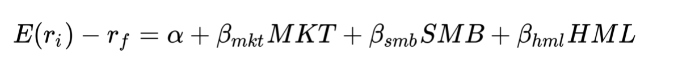

In [73]:

stock_returns = TSLA['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

In [74]:
ff_data.head()

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2018-02-28,-0.0365,0.0026,-0.0103,0.0011,-0.031752
2018-03-31,-0.0235,0.0406,-0.0023,0.0012,-0.224246
2018-04-30,0.0029,0.0110,0.0048,0.0014,0.104347
2018-05-31,0.0265,0.0531,-0.0313,0.0014,-0.031201
2018-06-30,0.0048,0.0113,-0.0233,0.0014,0.204474


In [75]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
'Add Constant to X'
X.insert(loc=0,value=np.ones(len(X)),column='I')
N = X.shape[1]

'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@y


#### Calculating the Intercept, coefficent of MKT_EXCESS, SML and HML

In [76]:
rf = ff_data['RF'].mean()
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()

intercept, b1, b2, b3 = beta_hat



In [77]:
print('------------------------\n')
print('Intercept ->',intercept)
print('MKT_EXCESS ->',b1)
print('SMB ->',b2)
print('HML ->',b3)

------------------------

Intercept -> 0.0367934330084816
MKT_EXCESS -> 2.3110519313202316
SMB -> -0.4187444814633103
HML -> -0.9269830945528542


#### Combining all the parameters into one functions to calculate the portfolio returns against the Fama French Model

In [78]:
expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return: " + str(expected_yearly_return))

Expected yearly return: 0.1551753598202423


### ARIMA Model ( Autoregressive Integrated Moving Average Model)

In [79]:
tsla = yf.Ticker("TSLA")

# To get stock info
tsla.info

# get historical market data as df
hist = tsla.history(period="max")

# Save dataframe as CSV file
hist.to_csv('TSLA.CSV')

# Read data in to dataframes
tsla = pd.read_csv('TSLA.CSV')

# Change date column to datetime type
tsla['Date'] = pd.to_datetime(tsla['Date'])

tsla.dropna(inplace=True)

<AxesSubplot:>

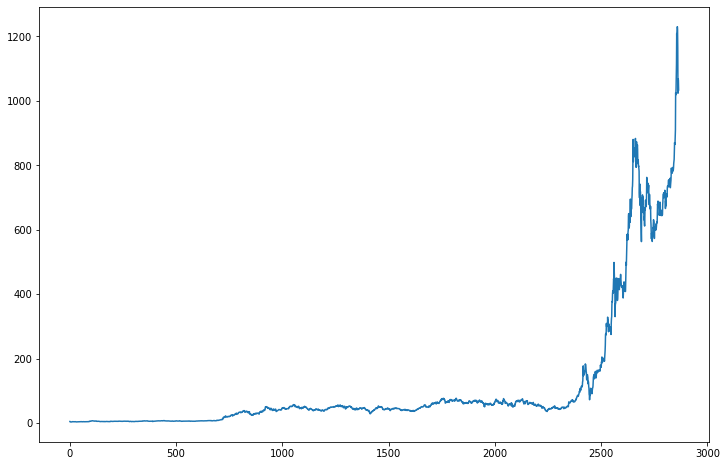

In [80]:
tsla['Close'].plot(figsize=(12,8))

In [81]:
series = tsla['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(tsla.Date == train_split_date)[0][0]
x_train = tsla.loc[tsla['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2018-01-02'
test_split_index = np.where(tsla.Date == test_split_date)[0][0]
x_test = tsla.loc[tsla['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = tsla.loc[(tsla['Date'] < test_split_date) & (tsla['Date'] > train_split_date)]['Close']

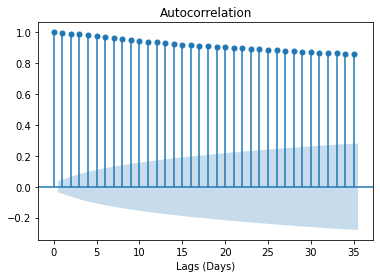

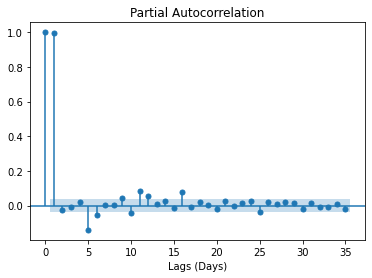

In [82]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(series)
plt.xlabel('Lags (Days)')
plt.show()

### When plotting the value of the ACF for increasing lags, the values tend to degrade to zero quickly for stationary time series , while for non-stationary data the degradation will happen more slowly hence we can conclude that the time series is not stationary

### We Also Perform Dickey-Fuller test

In [83]:
 #Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                    3.262862
p-value                           1.000000
#Lags Used                       19.000000
Number of Observations Used    2846.000000
Critical Value (1%)              -3.432650
Critical Value (5%)              -2.862556
Critical Value (10%)             -2.567311
dtype: float64


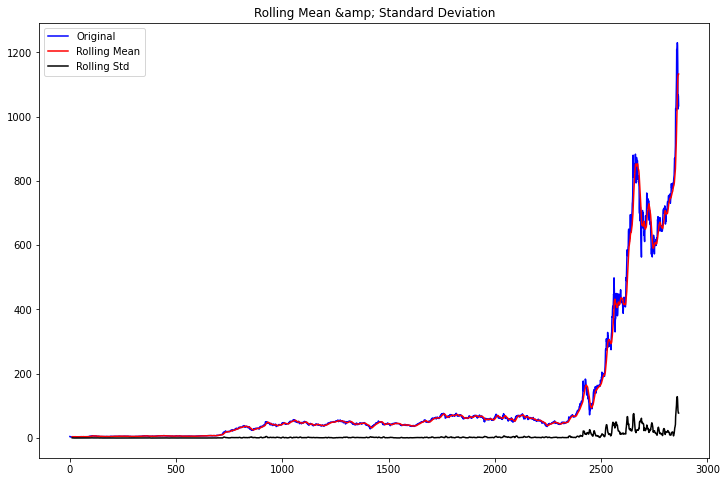

In [84]:
#Determing rolling statistics
rolmean = series.rolling(12).mean()
rolstd = series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()

In [85]:
#Convert our non-stationary data to stationary data using the differencing method
new_series= series.diff()
new_series.dropna(inplace=True)
#test_stationarity(new_series)

In [86]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(new_series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.058900e+01
p-value                        6.602382e-19
#Lags Used                     2.000000e+01
Number of Observations Used    2.844000e+03
Critical Value (1%)           -3.432651e+00
Critical Value (5%)           -2.862557e+00
Critical Value (10%)          -2.567311e+00
dtype: float64


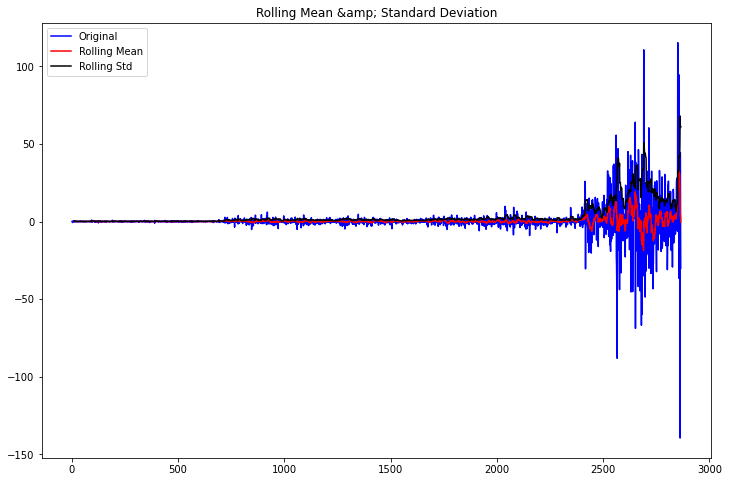

In [87]:
#Determing rolling statistics
rolmean = new_series.rolling(12).mean()
rolstd = new_series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(new_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()

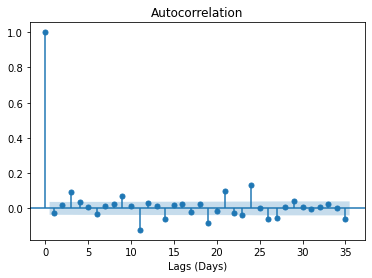

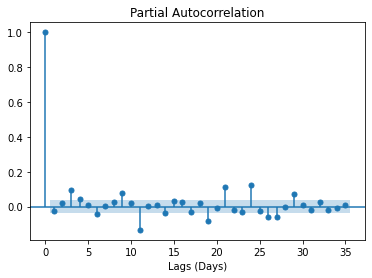

In [88]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

In [89]:
from statsmodels.tsa.arima_model import ARIMA


### Selecting the best p, d, q parameters for the ARIMA model by using the AIC (Akaike Information Critera )

In [90]:
import itertools
p=d=q=range(0,3)
pdq =list(itertools.product(p,d,q))

In [91]:

import warnings
warnings.filterwarnings("ignore")
AIC={}
for i in pdq:
    try:
        tsla_arima=ARIMA(x_train,order=(i))
        model_fit=tsla_arima.fit()
        print('AIC value -> ',model_fit.aic)
        print("(p,d,q) -> ",i)
        print('------------------------\n')
        AIC[model_fit.aic]=i
    except:
        continue

AIC value ->  12079.908181671082
(p,d,q) ->  (0, 0, 0)
------------------------

AIC value ->  10247.266521119902
(p,d,q) ->  (0, 0, 1)
------------------------

AIC value ->  8762.887548444043
(p,d,q) ->  (0, 0, 2)
------------------------

AIC value ->  3483.6817028572705
(p,d,q) ->  (0, 1, 0)
------------------------

AIC value ->  3485.594662890031
(p,d,q) ->  (0, 1, 1)
------------------------

AIC value ->  3487.005931737156
(p,d,q) ->  (0, 1, 2)
------------------------

AIC value ->  4431.980758096913
(p,d,q) ->  (0, 2, 0)
------------------------

AIC value ->  3491.2512338595993
(p,d,q) ->  (0, 2, 1)
------------------------

AIC value ->  3493.1502804881443
(p,d,q) ->  (0, 2, 2)
------------------------

AIC value ->  3495.8610269730943
(p,d,q) ->  (1, 0, 0)
------------------------

AIC value ->  3497.7288665313663
(p,d,q) ->  (1, 0, 1)
------------------------

AIC value ->  3499.253684387463
(p,d,q) ->  (1, 0, 2)
------------------------

AIC value ->  3485.598105161499
(

#### Finding the best parameter with minimum AIC value

In [92]:
print('Best parameters p, d and q ->',AIC[min(AIC.keys())])


Best parameters p, d and q -> (0, 1, 0)


In [93]:
### Fitting the model
tsla_arima = ARIMA(x_train, order=(0,1,0))
tsla_arima_fit = tsla_arima.fit(disp=0)
print(tsla_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1387
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1739.841
Method:                           css   S.D. of innovations              0.848
Date:                Sat, 13 Nov 2021   AIC                           3483.682
Time:                        08:39:49   BIC                           3494.151
Sample:                             1   HQIC                          3487.597
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.023      1.368      0.171      -0.013       0.076


In [94]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = mean_squared_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

# %store model_predictions

Testing Mean Squared Error is 229.50752655019207


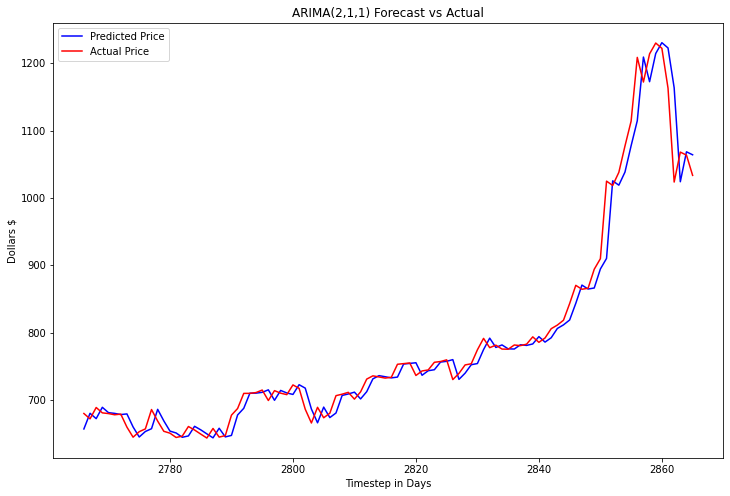

In [95]:
# Plot our predictions against the actual values for a visual comparison.
fig = plt.figure(figsize=(12, 8))
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(2,1,1) Forecast vs Actual')
plt.legend()

plt.savefig('TSLA_ARIMA_Predict.jpeg')
plt.show()


### K - means Clustering

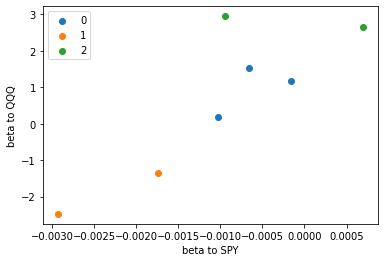

               0
Cluster index   
TSLA           1
GM             2
F              2
HMC            0
TM             0
RACE           0
NIO            1


In [111]:
#Clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as pyplot

# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', start_date,end_date)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
    # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', start_date,end_date)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', start_date,end_date)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


X = beta.transpose()
# K Mean Clustering
from sklearn.cluster import KMeans
# define the model
model = KMeans(n_clusters=3)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples


	plt.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)

# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()


df2 = pd.DataFrame(yhat,LIST)
index = df2.index
index.name = "Cluster index"
print(df2)

### Agglomerative Clustering

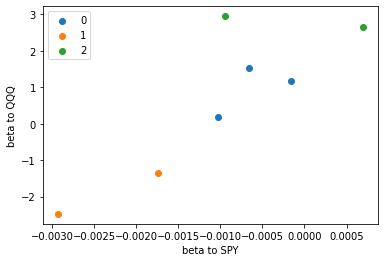

               0
Cluster index   
TSLA           1
GM             2
F              2
HMC            0
TM             0
RACE           0
NIO            1


In [112]:

# define the model
model = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)
# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()        
# print(yhat)

df1 = pd.DataFrame(yhat,LIST)
index = df1.index
index.name = "Cluster index"
print(df1)



In [ ]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

from datetime import datetime

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as ss
from pandas_datareader import DataReader

# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', startdate,enddate)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
 
 # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', startdate,enddate)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', startdate,enddate)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
    
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


fig = plt.figure(figsize = (10, 7))    
plt.scatter(beta[0,:], beta[1,:], color = 'b', s = 40,label='blue')
plt.xlabel('beta to SPY')
plt.ylabel('beta to QQQ')
plt.scatter(beta[0,:][beta[1,:]>1], beta[1,:][beta[1,:]>1], color = 'r', s= 80,label='red')
plt.legend()
plt.show()

model=IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

model.fit(beta.transpose())
scores = model.decision_function(beta.transpose())
pred = model.predict(beta.transpose())

In [ ]:
df3 = pd.DataFrame(LIST,pred)
df3